In [1]:
%load_ext autoreload
%autoreload 2
import enum
import os
from weakref import ref
import pandas as pd 
import openpyxl
import numpy as np
import re
from collections import deque, defaultdict, OrderedDict
from unicodedata import normalize
import itertools
import math
import seaborn as sns
import torch
from kde_model import KDENet,  train, build_df
import numpy as np
import japanize_matplotlib
import random
import torch 
from torch import nn
import torch.nn.functional as F
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'IPAexGothic'
import japanize_matplotlib

In [4]:
plt.plot(range(1, 20),)


Text(0.5, 1.0, 'Uhyよ')

In [2]:
from data_interpolation import read_excel_file, build_out_file, group_df_data_by_car, get_training_inputs

In [3]:
target_max = {'CO2排出量(g-CO2/km)_old': 500., "走行距離(km)_old": 12000.}
masks = {'走行距離(km)': 'distance_mask', 'CO2排出量(g-CO2/km)':'co2_mask'}

In [4]:
def get_out_df():
    dfs = read_excel_file()
    res_df = dict()
    for sheet, df in dfs.items():
        df = df.copy(deep=True)
        out_df = build_out_file(df)
        df2 = df.set_index([( '走行距離(km)', 'メーカー'), 
                            ( '走行距離(km)', 'ボディタイプ'),
                ])
        
        df2.index.set_names([ 'メーカー', 'ボディタイプ'], inplace=True)

        for training_col in ["走行距離(km)_old", 'CO2排出量(g-CO2/km)_old']:
            res_df[f"{training_col[:5]} - {sheet}"] = (df2, out_df)

    return res_df
          

In [5]:
res_df = get_out_df()

[('CO2排出量(g-CO2/km)', 'メーカー'), ('CO2排出量(g-CO2/km)', 'ボディタイプ'), ('合計 /  SUM(台数)', 'メーカー'), ('合計 /  SUM(台数)', 'ボディタイプ'), ('走行距離(km)_old', 'メーカー'), ('走行距離(km)_old', 'ボディタイプ'), ('CO2排出量(g-CO2/km)_old', 'メーカー'), ('CO2排出量(g-CO2/km)_old', 'ボディタイプ'), ('distance_mask', 'メーカー'), ('distance_mask', 'ボディタイプ'), ('co2_mask', 'メーカー'), ('co2_mask', 'ボディタイプ')]
[('CO2排出量(g-CO2/km)', 'メーカー'), ('CO2排出量(g-CO2/km)', 'ボディタイプ'), ('合計 /  SUM(台数)', 'メーカー'), ('合計 /  SUM(台数)', 'ボディタイプ'), ('走行距離(km)_old', 'メーカー'), ('走行距離(km)_old', 'ボディタイプ'), ('CO2排出量(g-CO2/km)_old', 'メーカー'), ('CO2排出量(g-CO2/km)_old', 'ボディタイプ'), ('distance_mask', 'メーカー'), ('distance_mask', 'ボディタイプ'), ('co2_mask', 'メーカー'), ('co2_mask', 'ボディタイプ')]
[('CO2排出量(g-CO2/km)', 'メーカー'), ('CO2排出量(g-CO2/km)', 'ボディタイプ'), ('合計 /  SUM(台数)', 'メーカー'), ('合計 /  SUM(台数)', 'ボディタイプ'), ('走行距離(km)_old', 'メーカー'), ('走行距離(km)_old', 'ボディタイプ'), ('CO2排出量(g-CO2/km)_old', 'メーカー'), ('CO2排出量(g-CO2/km)_old', 'ボディタイプ'), ('distance_mask', 'メーカー'), ('distance_mask', 'ボディタイプ'), ('co2_mask'

In [6]:
def plot_tsne(filename, df2, out_df):
  

    X = []

    data = torch.load(f'./data/MASTER/{filename}.pkl')
    net = KDENet()
    net.load_state_dict(data["params"])
    mu = data["mu"]

    training_col = "走行距離(km)_old" if filename.startswith('走行') else 'CO2排出量(g-CO2/km)_old'
    ref_col = training_col.replace('_old', '')
    r = group_df_data_by_car(df2.copy(deep=True), training_col)
    inputs, targets, engines = get_training_inputs(r, training_col)
    _df = r["BMW"]
    cars = {name: i for i, name in enumerate(r.keys())}
    body_types = { b:i for i, b in enumerate(_df['ボディタイプ'].values)}
    
    nclusters = mu.shape[0]
    for n in range(nclusters):
        X.append(mu[n].numpy())
    for j in range(len(out_df)):
        car, body = out_df[out_df.columns[0]][j], out_df[out_df.columns[1]][j]
        car, body = cars[car], body_types[body]
        cols = out_df.columns
        for k, eng in enumerate(out_df.iloc[j]):
            if k < 2:
                continue
            if cols[k][0] == ref_col:
                if cols[k][1] not in engines:
                    continue
                engine = engines[cols[k][1]]
                curr_val = out_df.iloc[j][k]
                import torch.nn.functional as F
                num_car=17
                num_box=25
                num_eng=6

                _cars = torch.tensor([car])
                _boxes = torch.tensor([body])
                _engines = torch.tensor([engine])

                _cars = F.one_hot(_cars, num_car).to(torch.float32)
                _boxes = F.one_hot(_boxes, num_box).to(torch.float32)
                _engines = F.one_hot(_engines, num_eng).to(torch.float32)
                with torch.no_grad():
                    out, feat = net(_cars, _boxes, _engines, mu)
                X.append(feat[0].numpy())
    X = np.stack(X)
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
    

    return X_embedded



In [7]:
X_res = dict()
for filename, (df2, out_df) in res_df.items():
    X = plot_tsne(filename, df2, out_df)
    X_res[filename] = X


/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py

In [8]:
def show_cluster(X, nclusters=5, filename=None):
    mu, feat = X[:nclusters], X[nclusters:]
    colors = {0: 'red', 1: 'green', 2: 'yellow', 3: 'blue', 4: 'orange'}
    feat_colors = []
    for i in range(feat.shape[0]):
        dst = feat[i] - mu
        dst = np.argmin((dst ** 2).sum(1))
        feat_colors.append(colors[dst])

    fig, ax = plt.subplots()
    for i, (x, y) in enumerate(mu):
        ax.scatter(x, y,    1000.0,color=colors[i], marker="o", label=f"mu_{i}",)

    for (x,y), color in zip(feat, feat_colors):
        ax.scatter(x, y, color=color)
    ax.set(title=filename)
    # TODO
    # if filename:
    #     plt.savefig(f'./data/MASTER/clusters/{filename}_cluster.png', )
    plt.show()


/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py

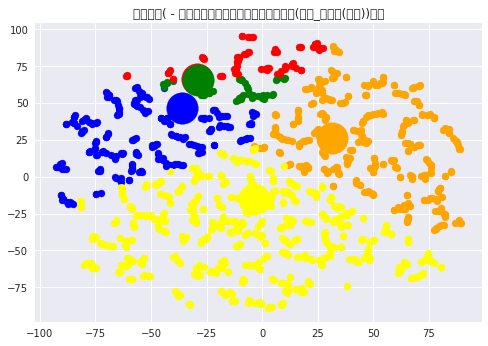

/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py

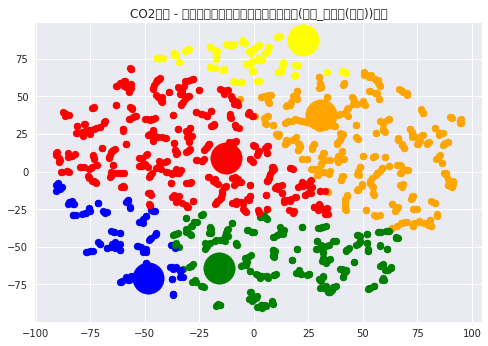

/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col][index] = 0.0
/home/barry/projects/nexco/toyota/data_interpolation.py

In [9]:
for filename, X in X_res.items():
    X = plot_tsne(filename, df2, out_df)
    show_cluster(X, filename=filename)
    
